In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

import sys
sys.path.append('../')
import utils

In [2]:
# Load dataset and add squared term
credit_score = pd.read_csv("../../data/credit_score.csv")

# Select features
features = ['INCOME','DEBT','R_EXPENDITURE','R_ENTERTAINMENT','CAT_GAMBLING']
X = credit_score[features].copy()

# One-hot encoding
X['GAMBLING_LOW'] = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
X.drop(columns=['CAT_GAMBLING'], inplace=True)

# Target variable
y = credit_score['CREDIT_SCORE']

In [3]:
# Train model
model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=3, n_estimators=100) 
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluating the model

Saving figure MA0_residuals


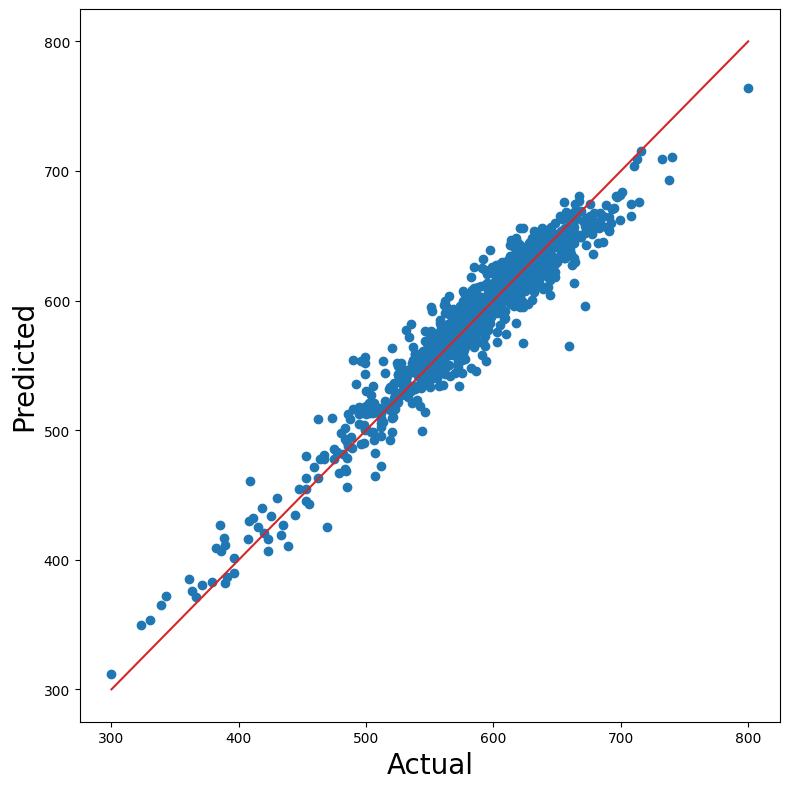

In [4]:
# Get predictions
y_pred = model.predict(X)

# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

# Save figure
utils.save_fig("MA0_residuals")

In [5]:
# Calculate performance metric
baseline_score = model.score(X, y)

baseline_score

0.9300410798128822

## Permute a feature

In [6]:
X_perm = X.copy()
X_perm['INCOME']= np.random.permutation(X_perm['INCOME'])

# Get predictions
y_pred = model.predict(X_perm)

Saving figure MA0_residuals_permuted


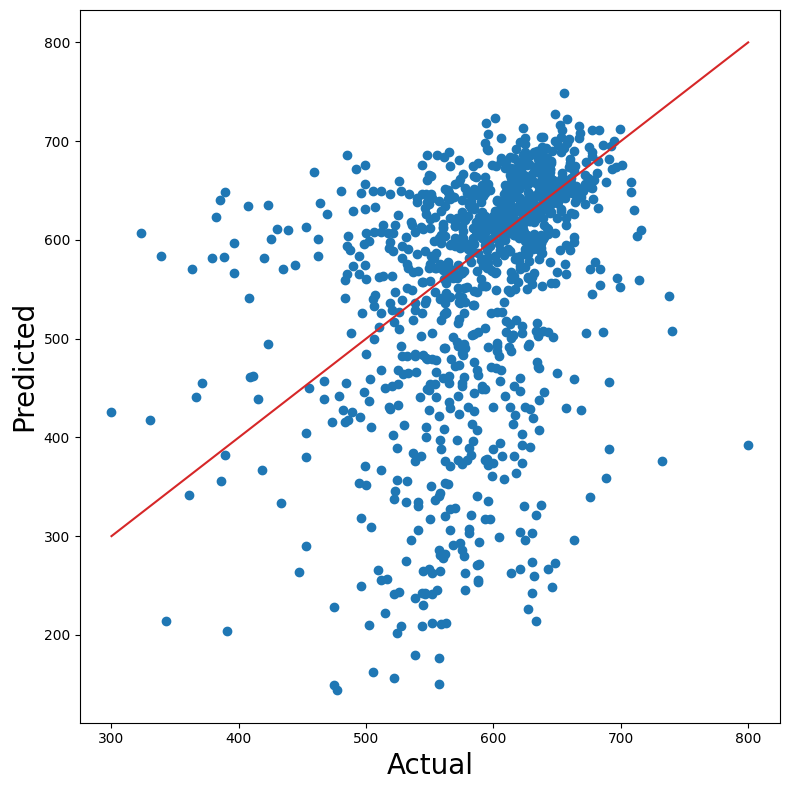

In [7]:
# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

# Save figure
utils.save_fig("MA0_residuals_permuted")

In [8]:
# calculate performance metric on permuted data
permuted_score = model.score(X_perm, y)
permuted_score

-2.894010790214516

## Permuatation importance from scratch

In [9]:
def get_perm_importance(model, X, y, features, n=5):

    """
    Calculate permutation importance score for each feature
    """

    # Calculate baseline score (without permuting any feature)
    baseline_score = model.score(X, y)

    importance_scores = {}

    # Loop over each feature
    for feature in features:

        X_perm = X.copy()
        sum_score = 0

        # Repeat n times to get average importance score
        for i in range(n):
           
            # Calculate score when given feature is permuted
            X_perm[feature]= np.random.permutation(X_perm[feature])
            permuted_score = model.score(X_perm, y)

            sum_score += permuted_score

        # Calculate decrease in score
        importance_score = baseline_score - sum_score/n
        importance_scores[feature] = importance_score

    return importance_scores


Saving figure MA0_fearture_importance


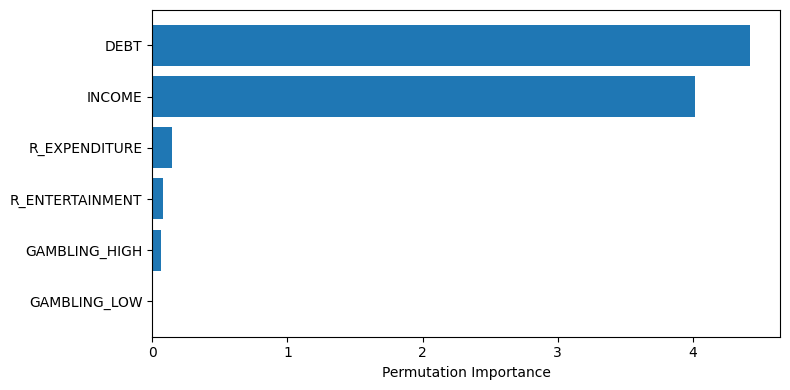

In [10]:
# Calculate permutation feature importance
importance_scores = get_perm_importance(model, X, y, X.columns,n=10)

# Display the importance scores using a horizontal bar plot
sorted_importance_scores = sorted(importance_scores.items(), key=lambda x: x[1])
features, scores = zip(*sorted_importance_scores)

plt.subplots(figsize=(8,4))
plt.barh(features, scores)
plt.xlabel('Permutation Importance')

# Save figure
utils.save_fig("MA0_fearture_importance")


In [11]:
credit_score.columns

Index(['CUST_ID', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME',
       'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6',
       'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS',
       'R_CLOTHING_DEBT', 'T_EDUCATION_12', 'T_EDUCATION_6', 'R_EDUCATION',
       'R_EDUCATION_INCOME', 'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT',
       'T_ENTERTAINMENT_12', 'T_ENTERTAINMENT_6', 'R_ENTERTAINMENT',
       'R_ENTERTAINMENT_INCOME', 'R_ENTERTAINMENT_SAVINGS',
       'R_ENTERTAINMENT_DEBT', 'T_FINES_12', 'T_FINES_6', 'R_FINES',
       'R_FINES_INCOME', 'R_FINES_SAVINGS', 'R_FINES_DEBT', 'T_GAMBLING_12',
       'T_GAMBLING_6', 'R_GAMBLING', 'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS',
       'R_GAMBLING_DEBT', 'T_GROCERIES_12', 'T_GROCERIES_6', 'R_GROCERIES',
       'R_GROCERIES_INCOME', 'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT',
       'T_HEALTH_12', 'T_HEALTH_6', 'R_HEALTH', 'R_HEALTH_INCOME',
       'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT', 'T_HOUSING_12', 'T_HOUSING_6',
 

## Using a package

Saving figure MA0_fearture_importance_sklearn


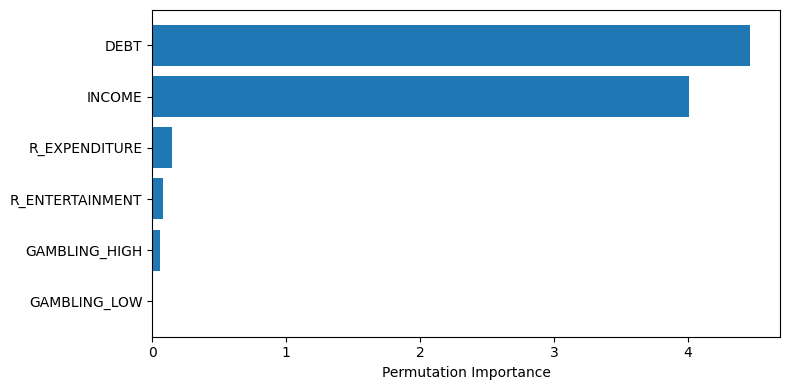

In [12]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
importance_scores = permutation_importance(model, X, y, n_repeats=10)

# Display the importance scores using a horizontal bar plot
sorted_idx = importance_scores.importances_mean.argsort()
features = X.columns[sorted_idx]
scores = importance_scores.importances_mean[sorted_idx]

plt.subplots(figsize=(8,4))
plt.barh(features, scores)
plt.xlabel('Permutation Importance')

# Save figure
utils.save_fig("MA0_fearture_importance_sklearn")
